<a href="https://colab.research.google.com/github/abdu355/ml701_project_grp20/blob/main/ml701_Proj_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Self-supervised Approach for Retinal OCT Scan Classification using SimCLR


## Transfer learning of pre-trained SimCLR Feature Extractor to Linear OCT Classifier

Using Pytorch Lightning API, we developed a powerful scan classifier for retinal OCT scans. The model was trained to choose between 4 different categories of scans:

- Normal
- CNV
- DME
- Drunsen

OCTModel achieves impressive accuracy, precision and recall, using 10% of labelled examples compare to previous methods dataset sizes. 

In [ ]:
%%capture
! pip install pytorch-lightning
! pip install git+https://github.com/PytorchLightning/pytorch-lightning-bolts.git@master --upgrade
! pip install image
! pip install comet-ml
! pip install captum
! pip install flask_compress
! pip install Pillow


## Importing libraries and Dataset

In [ ]:
# comet
from comet_ml import Experiment
from pytorch_lightning.loggers import CometLogger

# ----- general import -----
import torch
import pytorch_lightning as pl
import zipfile
import os
import pandas as pd
import numpy as np
import torch
import torchvision
from datetime import datetime

# ----- dataloader imports -----
# from flash import download_data
# from  pl_bolts.datamodules.async_dataloader import AsynchronousLoader
from torch.utils.data import Dataset, DataLoader
from PIL import Image

# ----- datamodule imports -----
from torch.utils.data import random_split
# from torch.utils.data import RandomSampler
import matplotlib.pyplot as plt
import math

# ----- data transforms imports -----
import torchvision.transforms as transforms
import torchvision.transforms.functional as tvf

# ----- model imports -----
from pl_bolts.models.self_supervised import SimCLR
from pytorch_lightning.callbacks import Callback
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from pl_bolts.models import LinearRegression, LogisticRegression
import torchvision.models as models
from argparse import Namespace
from pytorch_lightning.callbacks import LearningRateMonitor

# ----- evaluation imports -----
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve,RocCurveDisplay,plot_roc_curve,auc
from pytorch_lightning.metrics import ROC
# ----- check kernel device -----
# if you get CPU, change Runtime type to GPU. Top menu: Runtime > Change Runtime type > GPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## Download Training and Testing Datasets

Download the following datasets:
- Mendeley training and testing dataset (Kermany et al. [8])
- Duke University testing dataset (Srinivasan et al. [14])
- Github testing dataset (Wintergerst et al. [16])

In [ ]:
#load OCT data - $$$ keep in mind this action incurs a cost on AWS $$$
# from io import BytesIO
# from urllib.request import urlopen
# from zipfile import ZipFile
# zipurl = '' #to be updated
# with urlopen(zipurl) as zipresp:
#     with ZipFile(BytesIO(zipresp.read())) as zfile:
#         zfile.extractall('data/')
# zipurl = '' #to be updated
# with urlopen(zipurl) as zipresp:
#     with ZipFile(BytesIO(zipresp.read())) as zfile:
#         zfile.extractall('data/')

# download_data("", "data/")
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Load Image File Datasets

Define model hyper-parameters and file directory for training and teting Retinal OCT scans 

In [ ]:
#fix state for data seed
#class map
idx_to_label = {
    0: 'NORMAL',
    1: 'CNV',
    2: 'DME',
    3: 'DRUSEN'
}
random_state = 6

num_of_classes = int(len(idx_to_label))
frac_train_images = 1  
batch_size = 64 
optimizer = 'Adam' 

#load data from step above before setting root_dir
root_dir = 'data/OCT2017_M' 
root_dir_test = 'data/OCT_D'

In [ ]:
label_list = []
for key, value in idx_to_label.items():
    temp = value
    label_list.append(temp)
print(label_list)

#explore dataset
total_train = pd.read_csv(f"{root_dir}/train.csv")
data = total_train.sample(frac=frac_train_images, random_state=random_state)
print(f"total train data size: {total_train.shape}, sample train data size: {data.shape}")
data.head()

### Defining Dataloader and Transformer

In [ ]:
#dataset
class OCTDataset(Dataset):
    """ OCT Dataset """
    def __init__(self, root_dir, frac_train_images=1, transform=None, stage=False, random_state=1):
        if stage: 
            csv_output = pd.read_csv(os.path.join(root_dir_test, "test.csv"))
            self.images_dir = os.path.join(root_dir_test, "test")
        else:
            total_csv_output = pd.read_csv(os.path.join(root_dir, "train.csv"))
            csv_output = total_csv_output.sample(frac=frac_train_images, 
                                                 random_state=random_state)
            self.images_dir = os.path.join(root_dir, "train")

        self.image_urls = np.asarray(csv_output["image_id"])
        self.labels = np.asarray(csv_output["label"])
        self.transform = transform
        
    def __len__(self):
        return len(self.image_urls)
    
    def __getitem__(self, idx):
        # Get and load image
        image_path = os.path.join(self.images_dir, self.image_urls[idx])
        image = Image.open(image_path)
        # Perform transforms if any
        if self.transform:
            image = self.transform(image)
        # Get label
        label = self.labels[idx]   
        return image, label

In [ ]:
#datamodule
class OCTDataModule(pl.LightningDataModule):
    """ OCT DataModule for Lightning """
    def __init__(self, root_dir, frac_train_images=1, transform=None, batch_size=32, random_state=1):
        super().__init__()
        self.batch_size = batch_size
        self.root_dir = root_dir
        self.transform = transform
        self.frac_train_images = frac_train_images
        self.random_state = random_state
        
    def setup(self, stage=None):
        oct_full = OCTDataset(root_dir=self.root_dir, transform=self.transform, 
                              frac_train_images=self.frac_train_images, 
                              random_state=self.random_state)
        train_data_len = math.floor(len(oct_full) * 0.7)
        val_data_len = len(oct_full) - train_data_len
        # Create train and validation datasets
        self.oct_train, self.oct_val = random_split(oct_full, [train_data_len, val_data_len], 
                                                    generator=torch.Generator().manual_seed(random_state))
        
        # Create test dataset
        self.oct_test = OCTDataset(root_dir=self.root_dir, transform=self.transform, stage=True)

    def train_dataloader(self):
        return DataLoader(self.oct_train, batch_size=self.batch_size,
                          num_workers=8)
    
    def val_dataloader(self):
        return DataLoader(self.oct_val, batch_size=self.batch_size, 
                          num_workers=8)
    
    def test_dataloader(self):
        return DataLoader(self.oct_test, batch_size=self.batch_size, 
                          num_workers=8)

### Create OCTDataModule object

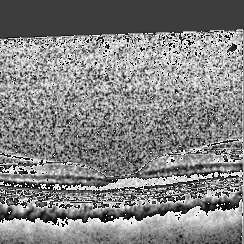

In [ ]:
#transforms on OCT data
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((244, 244)),
    transforms.ToTensor(),
    # ImageNet Normalization
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) 
    ])

# random_state = 6
num_of_classes = 4

# update batch_size: 32, 64, 128
oct_data = OCTDataModule(root_dir=root_dir, transform=transform, batch_size=batch_size, 
                         frac_train_images=frac_train_images, random_state=random_state)
oct_data.setup()

ds_train = oct_data.oct_train
tvf.to_pil_image(ds_train[6][0][0])

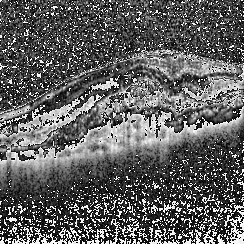

In [ ]:
ds_test = oct_data.oct_test
tvf.to_pil_image(ds_test[6][0][0])

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning:

This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


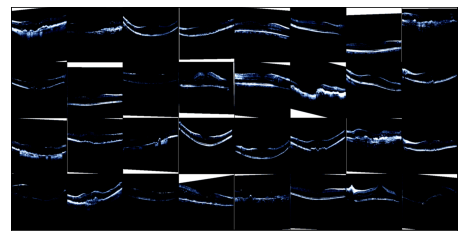

In [ ]:
train_dl = oct_data.train_dataloader()
batch = next(iter(train_dl))[0]
def show_images(images, nmax=32):
  fig, ax = plt.subplots(figsize=(8, 8))
  ax.set_xticks([]); ax.set_yticks([])
  ax.imshow(torchvision.utils.make_grid(images, nrow=8).permute(1, 2, 0))
show_images(batch)

## Fine-tuning & Classifier

In [ ]:
# unfreeze params post warm-up.  Can be used with any model.
class UnFreezeCallback(Callback): 
  def on_epoch_end(self, trainer, pl_module):
    if trainer.current_epoch == 10:
      pl_module.base_model.unfreeze()

class CometLogCallback(Callback):
    def on_epoch_end(self, trainer, pl_module):
      pl_module.logger.experiment.log_embedding(pl_module.reps, label_list)

In [ ]:
# model
# self.accuracy requires PL 1.1.8 https://github.com/PyTorchLightning/pytorch-lightning-bolts/issues/551
# TODO: add attention map implementation. # https://captum.ai/tutorials/Resnet_TorchVision_Interpret
# TODO: upload images and labels. comet.ml log_image
# TODO: Embeddings map and PCA. # https://www.comet.ml/docs/user-interface/embeddings/#logging-embeddings

class OCTModel(pl.LightningModule):
    def __init__(self, hparams):
        super().__init__()
        hparams = Namespace(**hparams) if isinstance(hparams, dict) else hparams
        self.save_hyperparameters(hparams)

        # load simCLR pre-trained on imagenet for feature extraction  
        self.base_model = SimCLR.load_from_checkpoint(self.hparams.embeddings_path, 
                                                 strict=False)     
        # Set some params
        self.tune = self.hparams.tune
        # self.accuracy = pl.metrics.Accuracy()
        num_target_classes = self.hparams.n_classes
        
        #freeze
        if self.hparams.freeze_base:
            self.base_model.eval()  

        # Use the pretrained simclr model representations to classify oct. 
        self.classifier = nn.Sequential(
            nn.Linear(self.base_model.encoder.fc.in_features, 
                      self.base_model.encoder.fc.in_features),
            nn.ReLU(),
            nn.Linear(self.base_model.encoder.fc.in_features, 
                      num_target_classes if num_target_classes > 2 else 1),
        )
        
        # Create loss function
        self.loss_fn = torch.nn.CrossEntropyLoss()
    
    def configure_optimizers(self):
        # https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.OneCycleLR
        # optimizers: Adagrad, SGD, Adam, LBFGS, RMSProp, Adamax
        # update
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate,) 
        lr_scheduler = {'scheduler': torch.optim.lr_scheduler.OneCycleLR(
                                        optimizer,
                                        max_lr=self.hparams.learning_rate,
                                        steps_per_epoch=int(self.hparams.steps_per_epoch),
                                        epochs=self.hparams.max_epochs,
                                        anneal_strategy="linear",
                                        final_div_factor = 30,
                                        cycle_momentum=False
                                    ),
                        'name': 'learning_rate',
                        'interval':'step',
                        'frequency': 1}
        return [optimizer], [lr_scheduler]
         
    def forward(self, input_data):
        representations = self.base_model(input_data)
        preds = self.classifier(representations)
        # self.reps = representations
        return preds
    
    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        predictions = self.forward(x)
        loss = self.loss_fn(predictions, y)
        self.log('train_loss', loss)
        return {'loss': loss}
    
    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        predictions = self.forward(x)
        loss = self.loss_fn(predictions, y)
        self.log('val_loss', loss)

### Finding best Learning rate parameter for initialization

In [ ]:
# simCLR weight path
weight_path = 'https://pl-bolts-weights.s3.us-east-2.amazonaws.com/simclr/bolts_simclr_imagenet/simclr_imagenet.ckpt'
hparams = Namespace(
    learning_rate=1e-3,
    freeze_base=True,
    tune=True,
    max_epochs=15,
    steps_per_epoch = len(oct_data.train_dataloader()),
    n_classes=num_of_classes,
    embeddings_path=weight_path,
    batch_size=batch_size,
    optimizer=optimizer,
    arch='resnet50',
    frac_train_images=frac_train_images
)

#init model
model = OCTModel(hparams)

#tune
trainer = pl.Trainer(gpus=1)
lr_finder = trainer.tuner.lr_find(model,datamodule=oct_data)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning:

This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.

Downloading: "https://pl-bolts-weights.s3.us-east-2.amazonaws.com/simclr/bolts_simclr_imagenet/simclr_imagenet.ckpt" to /root/.cache/torch/hub/checkpoints/simclr_imagenet.ckpt


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type             | Params
------------------------------------------------
0 | base_model | SimCLR           | 30.0 M
1 | classifier | Sequential       | 4.2 M 
2 | loss_fn    | CrossEntropyLoss | 0     
------------------------------------------------
34.2 M    Trainable params
0         Non-trainable params
34.2 M    Total params
136.897   Total estimated model params size (MB)


Restored states from the checkpoint file at /content/lr_find_temp_model.ckpt


suggested learning rate:  0.0019054607179632484


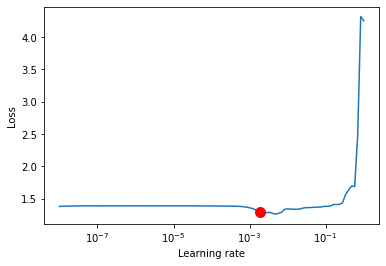

In [ ]:
# Inspect results
lr_finder.plot(show=False, suggest=True)
suggested_lr = lr_finder.suggestion()
print('suggested learning rate: ', suggested_lr)


### Running Classifier model with best initialization parameters

In [ ]:
# Overwrite lr and create new model
weight_path = 'https://pl-bolts-weights.s3.us-east-2.amazonaws.com/simclr/bolts_simclr_imagenet/simclr_imagenet.ckpt'
hparams = Namespace(
    learning_rate=suggested_lr,
    freeze_base=True,
    tune=False,
    max_epochs=15,
    steps_per_epoch = len(oct_data.train_dataloader()),
    n_classes=num_of_classes,
    embeddings_path=weight_path,
    batch_size=batch_size,
    optimizer=optimizer,
    arch='resnet50',
    frac_train_images=frac_train_images
)

model_tuned = OCTModel(hparams)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning:

This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



In [ ]:
# Define experiment params
experiment_num = 1
date=datetime.today().strftime('%Y%m%d')
experiment_name=f"OCT_classifier_{int(frac_train_images * 100)}_{optimizer}_{experiment_num}_{date}" 
project_name=""

lr_logger = LearningRateMonitor(logging_interval='step')
# Initialize comet logger using your own account.
comet_logger = CometLogger(
    api_key="<you_api_key>",
    workspace="",
    project_name=project_name,
    experiment_name=experiment_name
)
print(f"{experiment_name} comet.ml project: {project_name}")

# checkpoint callback - log at each epoch
checkpoint_callback=pl.callbacks.ModelCheckpoint(
    dirpath=experiment_name + '_ckp',
    monitor='val_loss',
    filename='{epoch}-{train_loss:.2f}-{val_loss:.2f}'    
)

# Define the trainer for our classifier and fit OCT data
trainer = pl.Trainer(max_epochs=hparams.max_epochs,
                     progress_bar_refresh_rate=20,
                     gpus=1,
                     logger=comet_logger,
                     callbacks=[checkpoint_callback, 
                                UnFreezeCallback(), 
                                lr_logger ])
trainer.fit(model_tuned, datamodule=oct_data)

#save checkpoint with weights
checkpoint_file="octmodel.ckpt"
torch.save(model_tuned.state_dict(), 'octmodel')
trainer.save_checkpoint(checkpoint_file)

# save model to comet
# comet_logger.experiment.log_asset(checkpoint_file, step="classifier_training")
comet_logger.experiment.log_model(experiment_name, './octmodel')
comet_logger.experiment.log_model(experiment_name, './octmodel.ckpt')

CometLogger will be initialized in online mode
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


OCT_classifier_100_Adam_2_20210418 comet.ml project: ml701-ssl-project


COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/abdusah-mbzuai/ml701-ssl-project/0b5b75fd3a0e4b36938ae11134fa67d0


  | Name       | Type             | Params
------------------------------------------------
0 | base_model | SimCLR           | 30.0 M
1 | classifier | Sequential       | 4.2 M 
2 | loss_fn    | CrossEntropyLoss | 0     
------------------------------------------------
34.2 M    Trainable params
0         Non-trainable params
34.2 M    Total params
136.897   Total estimated model params size (MB)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning:

This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excess

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/abdusah-mbzuai/ml701-ssl-project/0b5b75fd3a0e4b36938ae11134fa67d0
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     learning_rate [34] : (1.8438025348868582e-05, 0.0018590151129628941)
COMET INFO:     loss [205]         : (1.0541590199864004e-05, 1.3913003206253052)
COMET INFO:     train_loss [34]    : (2.0496207071118988e-05, 0.31184443831443787)
COMET INFO:     val_loss [15]      : (0.09780868142843246, 0.6343678832054138)
COMET INFO:   Others:
COMET INFO:     Name : OCT_classifier_100_Adam_2_20210418
COMET INFO:   Parameters:
COMET INFO:     arch              : resnet50
COMET INFO:     batch_size        : 32
COMET INFO:     embeddings_path   : https://pl-bolts-weights.s3.us-east-2.amazonaws.com/simclr/bolts_simclr_imagenet/simclr_imagen

{'api': 'https://www.comet.ml/api/rest/v2/experiment/asset/get-asset?assetId=520f007dc2e64fa48fc091265bd9693e&experimentKey=0b5b75fd3a0e4b36938ae11134fa67d0',
 'assetId': '520f007dc2e64fa48fc091265bd9693e',
 'web': 'https://www.comet.ml/api/asset/download?assetId=520f007dc2e64fa48fc091265bd9693e&experimentKey=0b5b75fd3a0e4b36938ae11134fa67d0'}

## Evaluation

Define an evaluation function to use for new image examples

In [ ]:
def evaluate(data_loader,module):
    with torch.no_grad():
        module.eval() 
        print('set model eval mode')
        true_y, pred_y, score_y = [], [], []
        print('ready')
        for i, _batch in enumerate(data_loader):       
            x, y = _batch
            y_score = module(x)    
            y_pred = torch.argmax(y_score, dim=1)
            true_y.extend(y)
            pred_y.extend(y_pred)
            score_y.extend(y_score)
            print(f"batch {i} done")
        print('eval done')
        return true_y, pred_y, score_y

Apply function on `oct_data.test_dataloader()`



In [ ]:
# Evaluate predictions on test data
ds_test = oct_data.test_dataloader()
true_y, pred_y, score_y = evaluate(ds_test, model_tuned)

Visualize confusion matrix of ground truth value against predicted values

In [ ]:
print(idx_to_label)
conf_matrix = confusion_matrix(true_y, pred_y)
print(conf_matrix)
comet_logger.experiment.log_confusion_matrix(
    labels=[idx_to_label[0],idx_to_label[1],idx_to_label[2],idx_to_label[3]],
    matrix=conf_matrix)

{0: 'NORMAL', 1: 'CNV', 2: 'DME', 3: 'DRUSEN'}
[[978   1  29  11]
 [  0 239  10   1]
 [224  17 774  25]
 [  0   2   0 143]]


{'api': 'https://www.comet.ml/api/rest/v2/experiment/asset/get-asset?assetId=900aeec08a724857b6f3279236a7fb06&experimentKey=0b5b75fd3a0e4b36938ae11134fa67d0',
 'assetId': '900aeec08a724857b6f3279236a7fb06',
 'web': 'https://www.comet.ml/api/asset/download?assetId=900aeec08a724857b6f3279236a7fb06&experimentKey=0b5b75fd3a0e4b36938ae11134fa67d0'}

Obtain a report on the four classes prediction with accuracy included

In [ ]:
report = classification_report(true_y, pred_y, digits=3)
print(report)
comet_logger.experiment.log_text(report)


COMET WARNING: Empty mapping given to log_params({}); ignoring


              precision    recall  f1-score   support

           0      0.814     0.960     0.881      1019
           1      0.923     0.956     0.939       250
           2      0.952     0.744     0.835      1040
           3      0.794     0.986     0.880       145

    accuracy                          0.870      2454
   macro avg      0.871     0.912     0.884      2454
weighted avg      0.882     0.870     0.867      2454



{'api': 'https://www.comet.ml/api/rest/v2/experiment/asset/get-asset?assetId=82f381cf186641ada949f5a9367c4809&experimentKey=0b5b75fd3a0e4b36938ae11134fa67d0',
 'assetId': '82f381cf186641ada949f5a9367c4809',
 'web': 'https://www.comet.ml/api/asset/download?assetId=82f381cf186641ada949f5a9367c4809&experimentKey=0b5b75fd3a0e4b36938ae11134fa67d0'}

In [ ]:
# TODO: show ROC curve per class or multi-class ROC

# fpr, tpr, thresholds = roc_curve(true_y, pred_y, pos_label=2)
# roc_auc = auc(fpr, tpr)

# roc = ROC(num_classes=4)
# fpr, tpr, thresholds = roc(np.array(score_y), np.array(pred_y))

# display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc,                                          estimator_name='example estimator')
# display.plot()  
# plt.show() 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
COMET ERROR: Could not convert image_data into an image; ignored


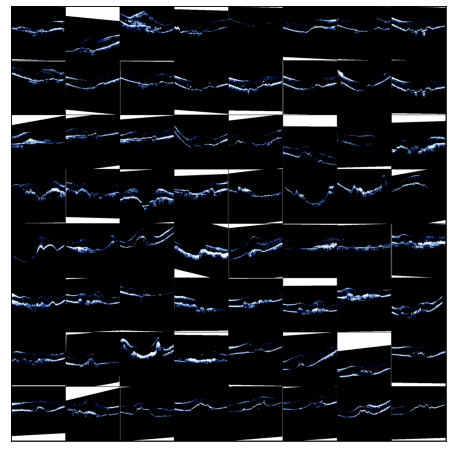

In [ ]:
test_dl = oct_data.test_dataloader()
batch = next(iter(test_dl))[0]
def show_images(images, nmax=32):
  fig, ax = plt.subplots(figsize=(8, 8))
  ax.set_xticks([]); ax.set_yticks([])
  ax.imshow(torchvision.utils.make_grid(images, nrow=8).permute(1, 2, 0))
  # comet_logger.experiment.log_image(images, name=f"test_sample")
show_images(batch)


In [ ]:
comet_logger.experiment.log_image('test_samples.png', name="test_samples_grid")
comet_logger.experiment.log_image('train_samples.png', name="train_samples_grid")

In [ ]:
# end experiment - must be called after you use experiment logger
comet_logger.experiment.end()

COMET INFO: -----------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: -----------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/abdusah-mbzuai/ml701-ssl-project/0b5b75fd3a0e4b36938ae11134fa67d0
COMET INFO:   Others:
COMET INFO:     Name : OCT_classifier_100_Adam_2_20210418
COMET INFO:   Uploads [count]:
COMET INFO:     confusion-matrix [2] : 2
COMET INFO:     model-element [2]    : 2
COMET INFO:     text-sample          : 1
COMET INFO: -----------------------------------
COMET INFO: Uploading 1 metrics, params and output messages


# Load Trained Model
Download latest model from registry https://www.comet.ml/abdusah-mbzuai/model-registry/oct-classifier-model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
suggested_lr = 0.0019054607179632484
weight_path = 'https://pl-bolts-weights.s3.us-east-2.amazonaws.com/simclr/bolts_simclr_imagenet/simclr_imagenet.ckpt'
hparams = Namespace(
    learning_rate=suggested_lr,
    freeze_base=True,
    tune=False,
    max_epochs=15,
    steps_per_epoch = 1000,
    n_classes=num_of_classes,
    embeddings_path=weight_path,
    batch_size=batch_size,
    optimizer=optimizer,
    arch='resnet50',
    frac_train_images=frac_train_images
)
model_loaded = OCTModel(hparams)
# import requests
# r = requests.get('https://www.comet.ml/api/rest/v2/registry-model/item/download?workspaceName=abdusah-mbzuai&modelName=oct-classifier-model&version=1.3.0', headers={'Authorization': 'oqnsyupYtRnpFlgmW4zBl7XxC'})

model_loaded.load_state_dict(torch.load('/content/drive/MyDrive/ML701/octmodel'))
# model_loaded


Downloading: "https://pl-bolts-weights.s3.us-east-2.amazonaws.com/simclr/bolts_simclr_imagenet/simclr_imagenet.ckpt" to /root/.cache/torch/hub/checkpoints/simclr_imagenet.ckpt


<All keys matched successfully>

# Test loaded model

In [ ]:
# Evaluate predictions on test data
ds_test = oct_data.test_dataloader()
true_y, pred_y, score_y = evaluate(ds_test, model_loaded)

print(idx_to_label)
conf_matrix = confusion_matrix(true_y, pred_y)
print(conf_matrix)

report = classification_report(true_y, pred_y, digits=3)
print(report)

# Model Interpretability



## Dimensionality Reduction for class separation

### t-SNE


https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial9/AE_CIFAR10.html#Finding-visually-similar-images


In [ ]:
# check for available model
if "model_tuned" not in globals():
  model_tuned = model_loaded
  print("model_tuned not here")

In [ ]:
from tqdm.notebook import tqdm

train_loader = oct_data.oct_train
test_loader = oct_data.oct_test


test_imgs = torch.zeros((3, 244, 244), dtype=torch.float32)
test_predictions = []
test_targets = []
test_embeddings = torch.zeros((0, 2048), dtype=torch.float32)
for x,y in tqdm(test_loader, desc="Predictions done", leave=False):
    embeddings = model_tuned.base_model.encoder(x.unsqueeze(0))
    logits = model_tuned.classifier(embeddings[0])

    preds = torch.argmax(logits, dim=1)
    test_predictions.extend(preds.detach().cpu().tolist())
    test_targets.append(y)
    test_embeddings = torch.cat((test_embeddings, embeddings[0].detach().cpu()), 0)
    test_imgs = torch.cat((test_imgs, x.detach().cpu()), 0)
    
test_imgs = np.array(test_imgs)
test_embeddings = np.array(test_embeddings)
test_targets = np.array(test_targets)
test_predictions = np.array(test_predictions)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
tsne = TSNE(2, verbose=1)
tsne_proj = tsne.fit_transform(test_embeddings)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2454 samples in 0.522s...
[t-SNE] Computed neighbors for 2454 samples in 11.384s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2454
[t-SNE] Computed conditional probabilities for sample 2000 / 2454
[t-SNE] Computed conditional probabilities for sample 2454 / 2454
[t-SNE] Mean sigma: 0.265371
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.574089
[t-SNE] KL divergence after 1000 iterations: 0.760912


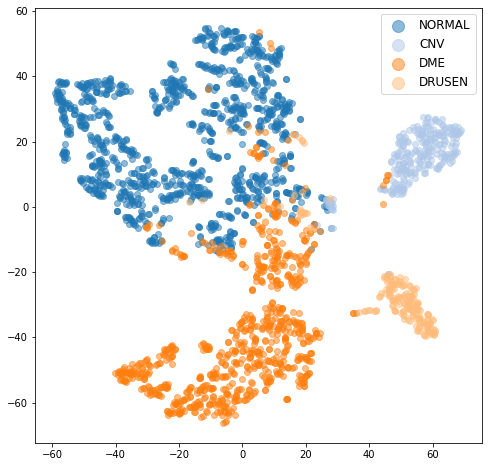

In [ ]:
from matplotlib import cm
cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8,8))
num_categories = 4
for lab in range(num_categories):
    indices = test_predictions==lab
    ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], c=np.array(cmap(lab)).reshape(1,4), label =  idx_to_label[lab] ,alpha=0.5)
ax.legend(fontsize='large', markerscale=2)
plt.show()


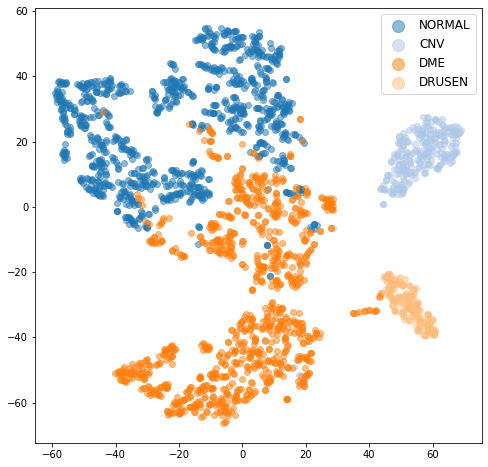

In [ ]:

cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8,8))
num_categories = 4
for lab in range(num_categories):
    indices = test_targets==lab
    ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], c=np.array(cmap(lab)).reshape(1,4), label =  idx_to_label[lab] ,alpha=0.5)
ax.legend(fontsize='large', markerscale=2)
plt.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2454 samples in 0.479s...
[t-SNE] Computed neighbors for 2454 samples in 11.413s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2454
[t-SNE] Computed conditional probabilities for sample 2000 / 2454
[t-SNE] Computed conditional probabilities for sample 2454 / 2454
[t-SNE] Mean sigma: 0.265371
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.003586
[t-SNE] KL divergence after 1000 iterations: 0.636554


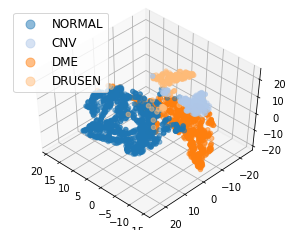

In [ ]:
tsne = TSNE(3, verbose=1)
tsne_proj = tsne.fit_transform(test_embeddings)
cmap = cm.get_cmap('tab20')
fig = plt.figure(1, figsize=(4, 3))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
num_categories = 4
for lab in range(num_categories):
    indices = test_predictions == lab
    ax.scatter(tsne_proj[indices, 0],
               tsne_proj[indices, 1],
               tsne_proj[indices, 2],
               c=np.array(cmap(lab)).reshape(1, 4),
               label=idx_to_label[lab],
               alpha=0.5)
ax.legend(fontsize='large', markerscale=2)
plt.show()

### PCA

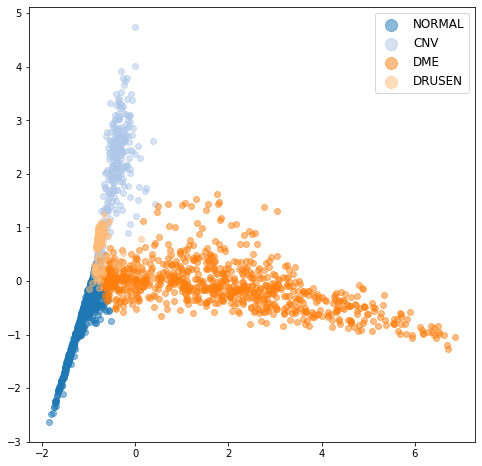

In [ ]:

pca = PCA(n_components=2)
pca.fit(test_embeddings)
pca_proj = pca.transform(test_embeddings)
pca.explained_variance_ratio_
cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8,8))
num_categories = 4
for lab in range(num_categories):
    indices = test_predictions==lab
    ax.scatter(pca_proj[indices,0],pca_proj[indices,1], c=np.array(cmap(lab)).reshape(1,4), label = idx_to_label[lab] ,alpha=0.5)
ax.legend(fontsize='large', markerscale=2)
plt.show()

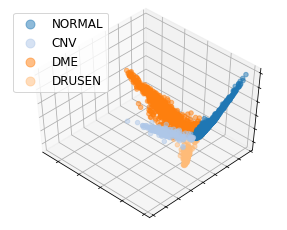

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

pca = PCA(n_components=3)
pca.fit(test_embeddings)
pca_proj = pca.transform(test_embeddings)
pca.explained_variance_ratio_
cmap = cm.get_cmap('tab20')
# fig, ax = plt.subplots(figsize=(8,8))
fig = plt.figure(1, figsize=(4, 3))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
num_categories = 4
for lab in range(num_categories):
    indices = test_predictions==lab
    ax.scatter(pca_proj[indices,0],pca_proj[indices,1],pca_proj[indices,2],label = idx_to_label[lab],c=np.array(cmap(lab)).reshape(1,4)
           ,alpha=0.5)
ax.legend(fontsize='large', markerscale=2)
plt.show()

In [ ]:
from sklearn.inspection import partial_dependence

## Convolutional Layer Activations 

### GradCAM

#### Captum Implementation

Using Captum API, we observe which pixels are positively and negatively activated for a particular class prediction.

We first check for the trained model, i.e. `model_tuned`, and then load the corresponding test dataframe. This dataframe will give us testing images in `root_dir_test` with the corresponding `label`.

In [ ]:
# check for available model
if "model_tuned" not in globals():
  model_tuned = model_loaded
  print("model_tuned not here")

In [ ]:
# load test image files dataframe
total_test = pd.read_csv(f"{root_dir_test}/test.csv")

#### Guided GradCAM

We first observe the guided backpropagation from the last convolution layer, which could be done for shallower layers. `GuidedGradCam` uses the model loaded and the layer we want to particularly explore. Then, we pass through any testing image to analyze which pixels on it get activated for a particular class prediction.

In [ ]:
import random
from PIL import Image
from captum.attr import GuidedGradCam
from captum.attr import visualization as viz

#### have resize transform for imported images
center_crop = transforms.Compose([
 transforms.Resize((244, 244)),
 transforms.Grayscale(num_output_channels=3),
])

vis_types = ["original_image", "blended_heat_map"]
vis_signs = ["all", "all"] # "positive", "negative", or "all" to show both

### randomly choose a row from text csv file
rand_idx = random.randint(0, total_test.shape[0])

oct_scan = total_test.image_id[rand_idx]
label = total_test.label[rand_idx]

idx_to_label = {0: 'NORMAL',
                1: 'CNV',
                2: 'DME',
                3: 'DRUSEN'}

img = Image.open(f'{root_dir_test}/test/' + oct_scan)

### transform the image
input = transform(img)
input = input.unsqueeze(0)

### start guided gradcam class
guided_gc = GuidedGradCam(model_tuned, 
                          model_tuned.base_model.encoder.layer4)

### pass image through guided gradcam
attribution = guided_gc.attribute(input.cpu(), int(label), 
                                 attribute_to_layer_input=False)

attribution = np.transpose(attribution.squeeze().cpu().detach().numpy(), 
                           (1,2,0))

### visualize image and pixel attributions
_ = viz.visualize_image_attr_multiple(attribution,
                                      np.array(center_crop(img)),
                                      vis_types,
                                      vis_signs,
                                      ['original image: ' + oct_scan, 
                                       "attribution for " + idx_to_label[label]],
                                      show_colorbar = True)

#### Layer GradCAM
 
We then investigate the layer attribution from the last convolution layer. It can be similarly done for shallower layers, but the authors and creators of **GradCAM** recommend the last convolutional layer for best results. `LayerGradCam` uses the model loaded and the layer we want to particularly explore. Then, we pass through any testing image to analyze which pixels on it get activated for a particular class prediction.
 
For the layer attribution method, we need to set `relu_attributions=True` in order to only observe those pixels that positively impact the prediction of a particular class.

In [ ]:
from PIL import Image
from captum.attr import LayerGradCam, LayerAttribution
from captum.attr import visualization as viz

#### have resize transform for imported images
center_crop = transforms.Compose([
 transforms.Resize((244, 244)),
 transforms.Grayscale(num_output_channels=3),
])

vis_types = ["original_image", "blended_heat_map"]
vis_signs = ["all", "all"] # "positive", "negative", or "all" to show both

### randomly choose a row from text csv file
rand_idx = random.randint(0, total_test.shape[0])

oct_scan = total_test.image_id[rand_idx]
label = total_test.label[rand_idx]

idx_to_label = {0: 'NORMAL',
                1: 'CNV',
                2: 'DME',
                3: 'DRUSEN'}

img = Image.open(f'{root_dir_test}/test/' + oct_scan)

### transform the image
input = transform(img)
input = input.unsqueeze(0)

### start layer gradcam class
layer_gc = LayerGradCam(model_tuned, 
                          model_tuned.base_model.encoder.layer4)

### pass image through layer gradcam
attribution = layer_gc.attribute(input.cpu(), int(label), 
                                 attribute_to_layer_input=False,
                                 relu_attributions=True)


### interpolate attributions from layer gradcam
upsampled_attr = LayerAttribution.interpolate(attribution, (244, 244))

upsampled_attr = np.transpose(upsampled_attr.squeeze(0).cpu().detach().numpy(), 
                              (1,2,0))

### visualize image and attibutes
_ = viz.visualize_image_attr_multiple(upsampled_attr,
                                      np.array(center_crop(img)),
                                      vis_types,
                                      vis_signs,
                                      ['original image: ' + oct_scan, 
                                       "attribution for " + idx_to_label[label]],
                                      show_colorbar = True)

#### Layer GradCAM on all Classes

Finally, we applied the concept from the previous cell but for all four classes. In this manner, we will be able to observe which pixels for a certain image positively influence the decision for every class prediction.

In [ ]:
from PIL import Image
from captum.attr import LayerGradCam, LayerAttribution
from captum.attr import visualization as viz

#### have resize transform for imported images
center_crop = transforms.Compose([
                                  transforms.Resize((244, 244)),
                                  ])

### randomly choose a row from text csv file
rand_idx = random.randint(0, total_test.shape[0])

oct_scan = total_test.image_id[rand_idx]
label = total_test.label[rand_idx]

idx_to_label = {0: 'NORMAL',
                1: 'CNV',
                2: 'DME',
                3: 'DRUSEN'}

img = Image.open(f'{root_dir_test}/test/' + oct_scan)

input = transform(img)
input = input.unsqueeze(0)

# CLASS PREDICTION
with torch.no_grad():
    model_tuned.eval() 
    embeddings = model_tuned.base_model.encoder(transform(img).unsqueeze(0))
    logits = model_tuned.classifier(embeddings[0])
    
    preds_prob = torch.nn.functional.softmax(logits, dim=1)
    y_score = model_tuned.forward(transform(img).unsqueeze(0))    
    y_pred = torch.argmax(y_score, dim=1)

predictions = np.array(preds_prob.detach().cpu().tolist())
    
print("predicted class: " + classes[y_pred])

## ATTRIBUTION MAPS
plt.figure(figsize=(15, 10))
plt.subplot(151)
# title of original image
plt.title(oct_scan)
plt.axis('off')
plt.imshow(center_crop(img), cmap='gray')

j = 1
for i in range(4):
    ### start layer gradcam class
    layer_gc = LayerGradCam(model_tuned,
                            model_tuned.base_model.encoder.layer4[-1])
    
    attribution = layer_gc.attribute(input.cpu(), i, 
                                     attribute_to_layer_input=False,
                                     relu_attributions=True)
    upsampled_attr = LayerAttribution.interpolate(attribution, (244, 244),
                                                  interpolate_mode="area")
    upsampled_attr = np.transpose(upsampled_attr.squeeze(0).cpu().detach().numpy(),
                                  (1,2,0))
    
    plt.subplot(151 + j)
    plt.title(f"{idx_to_label[i]}: p={predictions[0][i]:.3f}")
    plt.axis('off')
    plt.imshow(center_crop(img),
               cmap='gray')
    plt.imshow(upsampled_attr.squeeze(2), cmap='jet',
               alpha=min(0.5, predictions[0][i]))
    j += 1

# Serve Model

In [ ]:
%%capture
!pip install flask-ngrok
!pip install flask==0.12.2  # Newer versions of flask don't work in Colab
!pip install Werkzeug==0.16.1

In [ ]:
import io
import json

import torchvision.transforms as transforms
from PIL import Image
from flask import Flask, jsonify, request, send_file
from flask_ngrok import run_with_ngrok

from captum.attr import LayerGradCam, LayerAttribution
from captum.attr import visualization as viz

app = Flask(__name__)
run_with_ngrok(app)  # Start ngrok when app is run
# imagenet_class_index = json.load(open('drive/My Drive/imagenet_class_index.json'))
oct_class_index = {
    0: 'NORMAL',
    1: 'CNV',
    2: 'DME',
    3: 'DRUSEN'
}
model_loaded.eval()
# gradcam
vis_types = ["original_image", "blended_heat_map"]
vis_signs = ["all", "all"]  # "positive", "negative", or "all" to show both


def transform_image(image_bytes):
    my_transforms = transforms.Compose([
      transforms.Grayscale(num_output_channels=3),
      transforms.Resize((244, 244)),
      transforms.ToTensor(),
      # ImageNet Normalization
      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) 
    ])
    image = Image.open(io.BytesIO(image_bytes))
    return my_transforms(image).unsqueeze(0)

def crop_image(image_bytes):
    center_crop = transforms.Compose([
        transforms.Resize((244, 244)),
        transforms.Grayscale(num_output_channels=3),
    ])
    image = Image.open(io.BytesIO(image_bytes))
    return center_crop(image)


def get_prediction(image_bytes):
    tensor = transform_image(image_bytes=image_bytes)
    outputs = model_loaded.forward(tensor)
    _, y_hat = outputs.max(1)
    predicted_idx = int(y_hat.item())
    return predicted_idx,oct_class_index[predicted_idx]

def get_gradcam(image_bytes):
    class_id, _ = get_prediction(image_bytes=image_bytes)
    # print(class_id)
    # start layer gradcam class
    
    layer_gc = LayerGradCam(model_loaded,
                            model_loaded.base_model.encoder.layer4[-1])
    # pass image through layer gradcam
    attribution = layer_gc.attribute(transform_image(image_bytes=image_bytes), int(class_id),
                                     attribute_to_layer_input=False,
                                     relu_attributions=True)
    # interpolate attributions from layer gradcam
    upsampled_attr = LayerAttribution.interpolate(attribution, (244, 244))
    upsampled_attr = np.transpose(upsampled_attr.squeeze(0).detach().numpy(),
                                  (1, 2, 0))

    plt.title(f"class_id: {int(class_id)}")
    plt.axis('off')
    plt.imshow(crop_image(image_bytes),
               cmap='gray')
    plt.imshow(upsampled_attr.squeeze(2), cmap='jet',
               alpha=0.5)
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    new_img = Image.open(buf)
  
    return new_img

@app.route("/gradcam", methods=['POST'])
def gradcam():
    """Get gradcam"""  
    if request.method == 'POST':
        file = request.files['file']
        img_bytes = file.read()
    img_gradcam = get_gradcam(image_bytes=img_bytes)  
    bytes_io = io.BytesIO()
    img_gradcam.save(bytes_io, format="PNG")
    bytes_io.seek(0)
    return send_file(bytes_io, mimetype='image/png')

@app.route('/predict', methods=['POST'])
def predict():
    if request.method == 'POST':
        file = request.files['file']
        img_bytes = file.read()
        class_id, class_name = get_prediction(image_bytes=img_bytes)
        return jsonify({'class_id': class_id, 'class_name': class_name})

@app.route("/")
def info():
    return "Serving up pytorch model"

if __name__ == '__main__':
    app.run()

 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://1bdd5511ff31.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [03/May/2021 06:13:43] "POST /predict HTTP/1.1" 200 -
/usr/local/lib/python3.7/dist-packages/captum/_utils/gradient.py:55: UserWarning:

Input Tensor 0 did not already require gradients, required_grads has been set automatically.

127.0.0.1 - - [03/May/2021 06:13:47] "POST /gradcam HTTP/1.1" 200 -
127.0.0.1 - - [03/May/2021 06:14:41] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [03/May/2021 06:14:46] "POST /gradcam HTTP/1.1" 200 -
